# 文档归类课题报告
## 问题的定义
### 项目概述
文档分类是一个信息科学或者计算机科学领域内的课题,目标是能够将一个文档归为一类或者多类，可以通过人工或者算法的方式来实现。在这个课题中文档的内容由文本组成，分类的依据主要是根据文档的内容。<br>
在项目中主要使用算法来解决文档分类问题，所使用的算法主要是机器学习中的算法。包括Naive Bayes、Decision Tree、SVM、CNN等。在项目中所使用的数据集为[20 Newsgroups](http://www.qwone.com/~jason/20Newsgroups/),数据集中一共有20个分类，近2万篇文章。
### 问题陈述
文档分类属于多分类问题，需要根据输入的文章内容将文章准确的归为某一类别。在这个项目中一共有20个类别，每个文章只能从属于一个类别。
开始阶段将会对数据集进行分析，包括样本的数量以及分布，文档内容的一些特点。在熟悉完数据之后将会对文章进行一些清洗工作，去除干扰的特征项目，然后进行特征的提取、选择并且将处理好的特征输入到不同的模型当中进行训练与验证。
为了提高模型迭代的效率以及泛化能力，将数据分为训练集、验证集、测试集三个部分。按照9:1的比例划分数据，最后的1/10作为最终验证模型的测试数据，然后按照8:2的比例将剩余9/10的数据划分为训练集和验证集合。
### 评价指标
最后我们将会从两个维度来衡量模型：
- 准确率：$ accuracy = \sum_{i=1}^n I(y_i = y) / n $
(分类正确率的文档数除以总文档数)
- 时间：时间分为训练耗时和预测耗时。

## 数据的探索

In [2]:
from imp import  reload
from helper import to_sequence_by_w2v,get_doc_word_freq
from preprocess import *
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import train_test_split
from collections import Counter
from tqdm import tqdm_notebook as tn
import numpy as np
import pandas as pd
import math
from time import time

### 加载数据
由打印出的信息可以得出数据一共拥有19997个样本,一共有20个类目。

In [3]:
category= None
data = load_data('../data/20_newsgroups', categories = category, shuffle=True, skip_header=False)
X_data, X_test, Y_data, Y_test = \
    train_test_split(data['data'], data['labels'], test_size = 0.1, random_state=42)
        
print ('total category count:', len(data['label_names']))
print ('train document count: ', len(X_data))
print ('test document count: ', len(X_test))
print ('****************')
print (X_data[1])

total category count: 20
train document count:  17997
test document count:  2000
****************
Path: cantaloupe.srv.cs.cmu.edu!magnesium.club.cc.cmu.edu!news.sei.cmu.edu!cis.ohio-state.edu!zaphod.mps.ohio-state.edu!usc!sol.ctr.columbia.edu!destroyer!cs.ubc.ca!bcsystems!bclarke
From: bclarke@galaxy.gov.bc.ca
Newsgroups: rec.motorcycles
Subject: Re: First Bike??
Message-ID: <1993Apr20.081942.2307@galaxy.gov.bc.ca>
Date: 20 Apr 93 08:19:42 -0700
References: <0forqFa00iUzMATnMz@andrew.cmu.edu>
Organization: BC Systems Corporation
Lines: 8

In article <0forqFa00iUzMATnMz@andrew.cmu.edu>, James Leo Belliveau <jbc9+@andrew.cmu.edu> writes:
>     I am a serious motorcycle enthusiast without a motorcycle, and to
> put it bluntly, it sucks.  I really would like some advice on what would

Oh! For a second I thought this was a posting by Ed Green!
-- 
Bruce Clarke       B.C. Environment
                   e-mail: bclarke@galaxy.gov.bc.ca



### 每个类目的样本分布
分别对训练数据和测试数据不同类目的样本分布做统计, 发现大部分的类目样本数量还是比较接近的。

,category,train_doc_count,test_doc_count
7,rec.autos,877,123
5,comp.windows.x,884,116
16,talk.politics.guns,884,116
13,sci.med,887,113
10,rec.sport.hockey,890,110
2,comp.os.ms-windows.misc,892,108
1,comp.graphics,897,103
11,sci.crypt,898,102
12,sci.electronics,899,101
18,talk.politics.misc,899,101


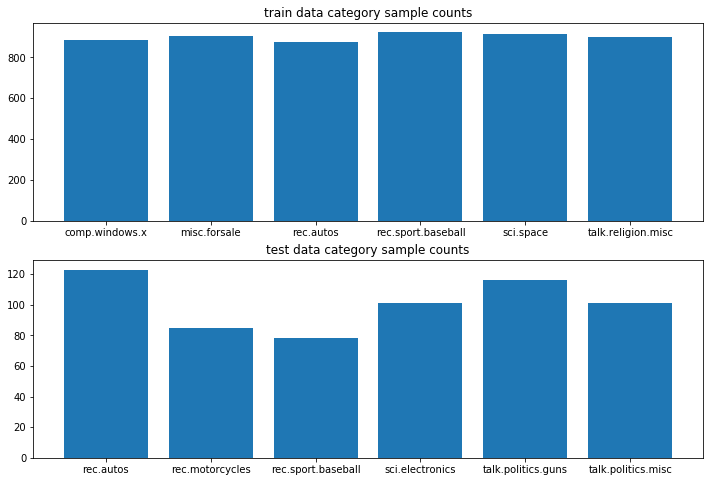

In [4]:
train_category_counter = dict()
for index, name in enumerate(data['label_names']):
    labels = np.asarray(Y_data)
    train_category_counter[name] = len(labels[labels == index])
df_cate_count = pd.DataFrame([i for i in train_category_counter.items()],columns=['category', 'train_doc_count'])

test_category_counter = dict()
for index, name in enumerate(data['label_names']):
    labels = np.asarray(Y_test)
    test_category_counter[name] = len(labels[labels == index])
t = pd.DataFrame([i for i in test_category_counter.items()],columns=['category', 'test_doc_count'])
df_cate_count = pd.merge(left=df_cate_count, right=t, on='category', how='inner')  
display (df_cate_count.sort_values(by = ['train_doc_count', 'test_doc_count']))

category_counter = np.asarray(sorted(train_category_counter.items(), key = itemgetter(1)))
index = [0,1,10,11,18,19]
fig, ax = plt.subplots(nrows=2, figsize=(12,8))
ax[0].bar([i[0] for i in category_counter[index]], height = [int(i[1]) for i in category_counter[index]])
ax[0].set_title('train data category sample counts')

category_counter = np.asarray(sorted(test_category_counter.items(), key = itemgetter(1)))
index = [0,1,10,11,18,19]
ax[1].bar([i[0] for i in category_counter[index]], height = [int(i[1]) for i in category_counter[index]])
ax[1].set_title('test data category sample counts')
plt.show()

上图的table中第一列为类目的名称，第二列和第三列分别统计的是训练集和测试.<br>
柱状图表示的是不同类目下的样本个数。

### 每篇文章的单词数的统计,以及总的词频分布统计
分析训练集和测试集样本中的词频分布，最常出现的单词，以及每篇文章中大概含有多少个有效单词。因为后面我们需要对文本特征进行提取，在提取之前了解这些特征的分布情况很有帮助。在项目中使用sklearn的CountVectorizer来进行统计，在当前统计中不做去停止词的操作，同样也不区分大小写。

In [8]:
def get_doc_word_freq(data):
    vectorizer = CountVectorizer()
    t = time()
    data_array = vectorizer.fit_transform(data)
    #print ('step 1 : ', time() - t)
    
    t = time()
    word_list = [word for word,index in sorted(vectorizer.vocabulary_.items(), key=itemgetter(1))]  
    #print ('step 2 : ', time() - t)
    
    t = time()
    total_word_count = len(word_list)
    words_counter_dict = dict()
    data_array = data_array.toarray()
    for i in range(0, total_word_count):
        words_counter_dict[word_list[i]] = data_array[:,i].sum()
    #print ('step 3 : ', time() - t)
    
    t = time()
    doc_words_counter_list = [data_array[j].sum() for j in range(0, data_array.shape[0])]
    #print ('step 4 : ', time() - t)
    
    return doc_words_counter_list, words_counter_dict

#print (X_array.shape)
#print (X_array[:,0].toarray().shape)

In [9]:
train_doc_words_count, train_word_counter = get_doc_word_freq(X_data)
test_doc_words_count, test_word_counter = get_doc_word_freq(X_test)

train document mean words count :  362.642273712  test document mean words count :  351.005
train document max words count  :  22679  test document max words count  :  12875
train document min words count  :  54  test document min words count  :  55
train total words count :  6526473 test total words count :  702010


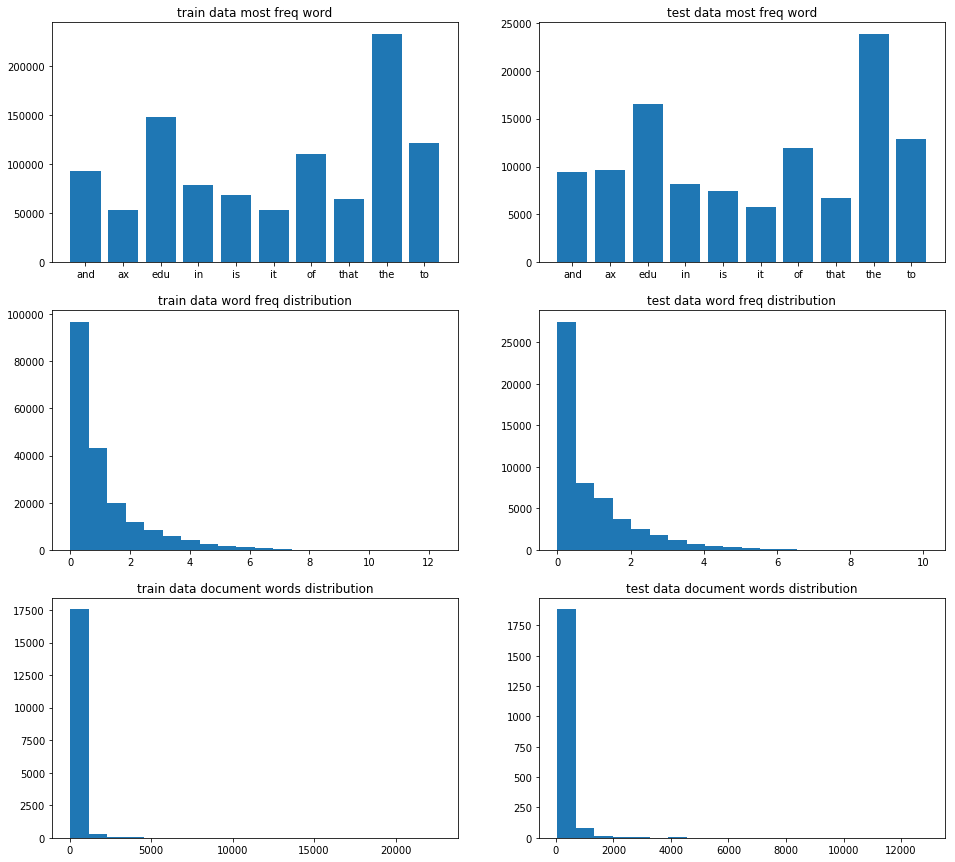

In [11]:
train_doc_words_count = np.asarray(train_doc_words_count)
test_doc_words_count = np.asarray(test_doc_words_count)
print ('train document mean words count : ', train_doc_words_count.mean(), 
       ' test document mean words count : ', test_doc_words_count.mean())
print ('train document max words count  : ', train_doc_words_count.max(),
       ' test document max words count  : ', test_doc_words_count.max())
print ('train document min words count  : ', train_doc_words_count.min(),
       ' test document min words count  : ', test_doc_words_count.min())
train_w =  sorted(train_word_counter.items(), key = itemgetter(1), reverse = True)
test_w = sorted(test_word_counter.items(), key = itemgetter(1), reverse = True)
print ('train total words count : ', sum([i[1] for i in train_w]),
       'test total words count : ', sum([i[1] for i in test_w]))

fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(16,15))

ax[0,0].bar([i[0] for i in train_w[0:10]], height = [int(i[1]) for i in train_w[0:10]])
ax[0,0].set_title('train data most freq word')

ax[0,1].bar([i[0] for i in test_w[0:10]], height = [int(i[1]) for i in test_w[0:10]])
ax[0,1].set_title('test data most freq word')

ax[1,0].hist([math.log(i[1]) for i in train_w], bins=20)
ax[1,0].set_title('train data word freq distribution')

ax[1,1].hist([math.log(i[1]) for i in test_w], bins=20)
ax[1,1].set_title('test data word freq distribution')

ax[2,0].hist(train_doc_words_count, bins=20)
ax[2,0].set_title('train data document words distribution')

ax[2,1].hist(test_doc_words_count, bins=20)
ax[2,1].set_title('test data document words distribution')

plt.show()

由左边的两幅图可以得知最近常出现的几个词大都没有什么具体的含义，在后面特征提取的过程中会当做停止词去掉。<br>
由右边的图为词频的分布统计，因为词频相差的太大显示效果比较差，所以对词频做了log处理，显示的时候会更友好一些。由分布可知<br>
绝大部分的词语在训练集和测试集只出现过几次，针对这些词可以在后面做特征处理的时候去掉，避免特征太多增加模型的复杂度。

### 算法和技术

这是一个文本分类问题，首先需要将文本转化为可以量化的特征才能使用机器学习算法进行训练。目前使用非常广泛的算法为TF-IDF的表示方式，其原理
是将文章表示为一个词列表，列表中每个词的权重由词频和其所出现的文档数共同决定的。直观上理解就是一个词的词频越高并且在越少的文章中出现则该词的信息量越大，这样的表示方式非常简单且很有效果。但是这种表示丢失了词与词之间的顺序关系，并且不能解决近义词的问题。词向量能很好的解决这个问题，把文章按照其词语出现的顺序和词向量一起组成一个n(词个数)*m(词向量维度)的矩阵也是一个比较好的方式。可以解决顺序和多词意的问题。<br>
模型选择上尝试的是SVM、naive bayes和CNN。前两个模型为统计学习方法中的模型，CNN为深度学习的模型，每个模型都有自己的优缺点。<br>
SVM:<br>
优点：svm会筛选出margin最大的线性分类器，这样的分类器泛化能力最好，并且使用核函数解决数据线性不可分的问题。当训练数据集并不大，并且分布和真实分布近似时效果最好。<br>
缺点：svm的模型较复杂，训练的时间较长，同时比较容易出现过拟合的现象。当数据量比较小时容易出现过拟合。当数据集规模较大，模型的训练时间较长，模型的迭代周期会变得很长。<br>
naive bayes:<br>
优点：快速、易于训练。当训练数据的属性关联性比较弱，离散数据不太稀疏，连续数据符合高斯分布的时候效果最好。<br>
缺点：模型较简单，无法处理复杂的数据关系。朴素贝叶斯假设各个变量的关联性很弱，所以当每个feature关联性很强的时候效果很差。<br>
CNN:<br>
优点：能够提取局部相关的特征，捕捉不同局部的特征，并且最终将这些局部特征汇总起来。<br>
缺点：容易过拟合，对机器的性能要求较高，训练时间较长。<br>

### 基准模型

网络上有很多关于20newsgroup的研究和分类实验，斯坦福大学的正确率大概在85~90%左右。所以在这个项目上模型在测试集上的准确率在需要在90%以上。

## 方法

### 数据预处理

首先将文本中的英文全部转化为小写，因为Hello和hello在字面上是一个意思不应该被当做是两个特征。其次使用NLTK进行词干提取，这样做能够统一单词的单复数形式。去停止词、去除低频词这些操作可以不用在最开始做因为使用的sklearn和keras在文本特征处理的时候都自带去停止词功能，同样也支持文本特征选择和筛选功能非常方便。在该项目中尝试了两种表示文本文章，一种是TF-IDF+词袋模型，另一种是sequence+词向量。下面将分别对这两种方式进行介绍。<br>

TF-IDF+词袋模型:<br>
一篇文章被表示为一个向量，这个向量由文章中出现的词的TF-IDF值决定。我们使用sklearn来训练文档中的TF-IDF值，在训练完成后文章将被表示为的形式:<br>
矩阵的每一行表示一篇文章，每一列表示该单词是否在文中出现，如果出现则使用该单词的tf-idf值来表示，sklearn还会帮我们做归一化的处理。

In [24]:
TfidfVectorizer().fit_transform(['hello', 'hello do you like Udacity', 'I like Udacity']).toarray()

array([[ 0.        ,  1.        ,  0.        ,  0.        ,  0.        ],
       [ 0.51741994,  0.3935112 ,  0.3935112 ,  0.3935112 ,  0.51741994],
       [ 0.        ,  0.        ,  0.70710678,  0.70710678,  0.        ]])

使用词向量表示文章的示例：<br>
'this is a great'一共四个单词，最后被表示出来后就有4行，每一行依次代表一个单词，在这个示例中一共有100列因为使用的是100维的词向量。

In [25]:
d = to_sequence_by_w2v('this is a great')
print ('the shape of document: ', d.shape)
pd.DataFrame(d)

the shape of document:  (4, 100)


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-0.570580,0.441830,0.70102,-0.41713,-0.34058,0.02339,-0.071537,0.48177,-0.013121,0.16834,...,-0.085735,-0.105250,-0.515710,0.150380,-0.166940,-0.16372,-0.227020,-0.66102,0.47197,0.37253
1,-0.542640,0.414760,1.03220,-0.40244,0.46691,0.21816,-0.074864,0.47332,0.080996,-0.22079,...,-0.325280,-0.134600,-0.413140,0.334350,-0.007241,0.32253,-0.044219,-1.29690,0.76217,0.46349
2,-0.270860,0.044006,-0.02026,-0.17395,0.64440,0.71213,0.355100,0.47138,-0.296370,0.54427,...,0.572010,0.088945,-0.425320,-0.018253,-0.079995,-0.28581,-0.010890,-0.49230,0.63687,0.23642
3,-0.013786,0.382160,0.53236,0.15261,-0.29694,-0.20558,-0.418460,-0.58437,-0.773550,-0.87866,...,-0.101460,-0.263010,-0.061707,0.366270,-0.952230,-0.39346,-0.691830,-1.04260,0.28855,0.63056


### 执行过程

首先加载数据，并且将数据按照9:1的比例划分数据，最后的1/10作为最终验证模型的测试数据，然后按照8:2的比例将剩余9/10的数据划分为训练集和验证集合

In [134]:
category = None
data = load_data('../data/20_newsgroups', categories = category, shuffle=True, skip_header=False)
X_data, X_test_text, Y_data, Y_test = \
    train_test_split(data['data'], data['labels'], test_size = 0.1, random_state=42)
X_train_text, X_develop_text, Y_train, Y_develop = train_test_split(X_data, Y_data, test_size = 0.2, random_state=42)

tfidf = TfidfVectorizer()
X_train = tfidf.fit_transform(X_train_text)
X_develop = tfidf.transform(X_develop_text)

#### 基准模型
使用naive bayes和svm测试一下基准模型的准确率

In [135]:
def bechmodel(clf):
    t = time()
    clf.fit(X_train, Y_train)
    train_time = time() - t
    t = time()
    preds = clf.predict(X_develop)
    pred_time = time() - t
    accuracy = accuracy_score(Y_develop, preds)
    return accuracy, train_time, pred_time

In [136]:
from sklearn.naive_bayes import MultinomialNB
print ('MultinomialNB accuracy : %0.4f, train_time : %0.2fs, pred_time : %0.2fs' % (bechmodel(MultinomialNB())))
print ('LinearSVC accuracy : %0.4f, train_time : %0.2fs, pred_time : %0.2fs' % (bechmodel(LinearSVC(random_state=42))))

MultinomialNB accuracy : 0.8864, train_time : 0.29s, pred_time : 0.04s
LinearSVC accuracy : 0.9394, train_time : 3.44s, pred_time : 0.02s


经过试验发现使用naive bayes不做任何优化已经可以达到89%的正确率,svm正确率达到的94%,效果看起来很不错。

#### 模型调优
由之前的词频统计信息可以发现，大部分出现很频繁的词语并没有太多的含义，这部分词语可以被当做停止词去除掉。去去除掉停止词后发现模型的正确率有了提升，并且训练时间也减少了

In [137]:
tfidf = TfidfVectorizer(stop_words='english')
X_train = tfidf.fit_transform(X_train_text)
X_develop = tfidf.transform(X_develop_text)
print ('MultinomialNB accuracy : %0.4f, train_time : %0.2fs, pred_time : %0.2fs' % (bechmodel(MultinomialNB())))
print ('LinearSVC accuracy : %0.4f, train_time : %0.2fs, pred_time : %0.2fs' % (bechmodel(LinearSVC(random_state=42))))

MultinomialNB accuracy : 0.8994, train_time : 0.26s, pred_time : 0.04s
LinearSVC accuracy : 0.9394, train_time : 3.35s, pred_time : 0.02s


为了提升模型的调参效率，这里使用sklearn的GridSearch来进行模型的参数调整

In [41]:
from sklearn.grid_search import GridSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
pipe =  Pipeline([('tfidf', TfidfVectorizer()),
                  ('selectk', SelectKBest(chi2)),
                  ('clf', LinearSVC(random_state=42))])
parameters = {  
    'tfidf__stop_words': ('english', None),
    'tfidf__sublinear_tf': (False, True),
    'tfidf__stop_words': ('english', None),
    'selectk__k': (10000, 50000, 100000),
    'clf__tol': (1e-3,1e-4),
    'clf__max_iter': (1000, 5000)
}  

grid_cv = GridSearchCV(pipe, parameters,cv=5)
grid_cv.fit(X_train_text, Y_train)
grid_cv.best_params_

{'clf__max_iter': 1000,
 'clf__tol': 0.001,
 'selectk__k': 10000,
 'tfidf__stop_words': 'english',
 'tfidf__sublinear_tf': True}

发现使用最参数进行模型训练时，正确率比之前提升了一些达到了95.2%

In [131]:
pipe = Pipeline([('tfidf', TfidfVectorizer(stop_words = 'english', sublinear_tf=True)),
                  ('selectk', SelectKBest(chi2,k=10000)),
                  ('clf', LinearSVC(random_state=42, tol=0.001, max_iter=1000))])
pipe.fit(X_train_text, Y_train)
preds = pipe.predict(X_develop_text)
accuracy = accuracy_score(Y_develop, preds)
print ('pipe accuracy : %0.4f' % (accuracy))

pipe accuracy : 0.9517


#### 深度学习解决文本分类问题

之前的机器学习过程中使用的是词袋模型和tfidf来表示文本特征，这种表示方法会造成很大的稀疏性且相似的词语并不会有任何联系，同时也丢失了文本顺序这一个很重要的特征。所以我们使用词向量+sequence来表示文章并且通过CNN神经网络来训练模型。<br>
项目中可以使用gensim训练词向量，将wiki百科的英文语料生成一个300维的词向量,实际选择的是使用glove训练好的300维词向量。具体训练和验证过程可以执行keras_clf.py文件,日志文件保存在cnn_log.txt中。

以下为迭代次数与验证集正确率的曲线关系,可以发现一共有20次epoch。在第三次epoch的时候就达到了一个比较理想的状态，而且正确率要略高于之前的svm训练方法,但是cnn的训练时间较长，每一个epoch都要600s左右，完整训练一次需要花3.5个小时左右。

total epoch count:  20
total time comsume: 12500s


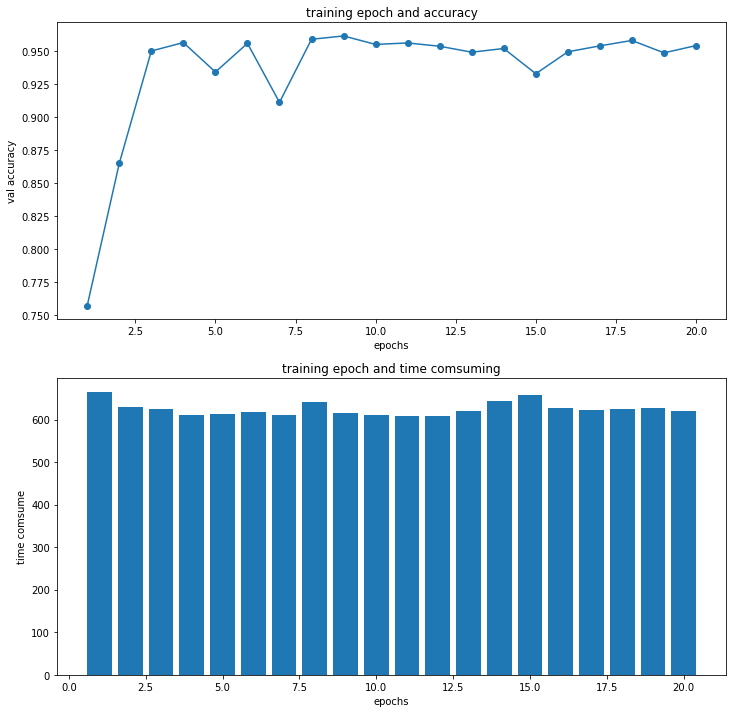

In [133]:
epoch_accuracys = []
train_time_comsume = []
with open('./cnn_log.txt') as fp:
    for line in fp.readlines():
        if (line.find('val_acc') >= 0):
            epoch_accuracys.append(float(line.strip('\n').split(' ')[-1]))
            train_time_comsume.append(int(line.strip('\n').split(' ')[3][:-1]))
fig, ax = plt.subplots(nrows=2,figsize=(12,12))
print ('total epoch count: ', len(epoch_accuracys))
print ('total time comsume: %ds'% sum(epoch_time_comsume))
ax[0].plot(np.arange(1, len(epoch_accuracys) + 1,1), epoch_accuracys, 'o-')
ax[0].set_xlabel('epochs')
ax[0].set_ylabel('val accuracy')
ax[0].set_title('training epoch and accuracy')

ax[1].bar(np.arange(1, len(epoch_time_comsume) + 1,1), train_time_comsume)
ax[1].set_xlabel('epochs')
ax[1].set_ylabel('time comsume')
ax[1].set_title('training epoch and time comsuming')
plt.show()

### 结论

#### 不同模型之间的对比
我们将从训练时间,准确率以及预测时间这几个维度来衡量上面的模型,在验证集上的准确率cnn>svm>bayes,但是训练时间和预测时间上cnn远远大于svm和bayes。所以综合这几个因数来考虑，选用svm作为这个问题的解决方案。并且在测试集上做最终的验证，正确率达到了95%。完成了之前预定的目标。

In [161]:
from sklearn.metrics import classification_report
preds = pipe.predict(X_test_text)
accuracy = accuracy_score(Y_test, preds)
print ('accuracy : ', accuracy)
print (classification_report(Y_test, preds, target_names=np.asarray(data['label_names'])))

accuracy :  0.948
                          precision    recall  f1-score   support

             alt.atheism       0.78      0.75      0.76        92
           comp.graphics       0.97      0.99      0.98       103
 comp.os.ms-windows.misc       0.95      0.99      0.97       108
comp.sys.ibm.pc.hardware       0.98      0.97      0.97        95
   comp.sys.mac.hardware       0.99      1.00      0.99        90
          comp.windows.x       1.00      0.94      0.97       116
            misc.forsale       0.96      0.98      0.97        98
               rec.autos       0.98      0.99      0.99       123
         rec.motorcycles       1.00      1.00      1.00        85
      rec.sport.baseball       1.00      1.00      1.00        78
        rec.sport.hockey       1.00      1.00      1.00       110
               sci.crypt       1.00      0.99      1.00       102
         sci.electronics       0.97      0.96      0.97       101
                 sci.med       1.00      0.98      0.99  

### 提高

- 每篇文章的开头包含了很多重要的信息，如果去掉文件头的话会发现正确率会下降到86%左右。而在真正的文档分类任务中往往只有文章内容，在项目中还是使用到了文章的开头来提取特征。
- EDA应该还有很多优化空间，比如提取词干等。在测试集中可能遇到之前没有出现过的词语，这时候可以做同义词转化等等。
- 还可以尝试更多的统计学习方法和深度学习方法。

### 引用

[1]文档分类的[问题描述](en.wikipedia.org/wiki/Document_classification) <br>
[2]sklearn的20newsgroups[官方示例](http://scikit-learn.org/stable/auto_examples/text/document_classification_20newsgroups.html#sphx-glr-auto-examples-text-document-classification-20newsgroups-py)<br>
[3]斯坦福glove词向量的[相关资料和数据](https://nlp.stanford.edu/projects/glove/)<br>
[4]文章中使用到的20news-19997.tar.gz[数据集](http://qwone.com/~jason/20Newsgroups/)<br>
[5]使用词嵌入解决文本分类问题[keras的示例](https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html)<br>
[6]gensim关于词向量的介绍以及[官方示例](https://radimrehurek.com/gensim/)<br>
[7]TF-IDF的[介绍](https://en.wikipedia.org/wiki/Tf%E2%80%93idf)